# Anchor-Probe/Probe-Probe/Anchor-Anchor Output Distance
**Goal**: Analyze the distance between the output representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
LAYER = 'output'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [4]:
all_anchors_data = []
all_probes_data = []


for dilution in tqdm(range(1, 4)):
    # ANCHORS
    anchor_list = sum(anchor_probe_mapping['anchor'].apply(lambda x: x[:dilution]).tolist(), [])
    anchor_types = [f"ANC_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    anchor_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-anchors-{LAYER}.pkl'),
                             pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-{LAYER}.pkl')])
    
    anchor_data = anchor_data[anchor_data['word_type'].isin(anchor_types)]
    anchor_data = anchor_data[anchor_data['orth'].isin(anchor_list)]
    anchor_data = anchor_data.drop_duplicates(subset=['epoch', 'orth'])
    anchor_data['dilution'] = dilution
    all_anchors_data.append(anchor_data)
    
    # PROBES
    probe_types = [f"PRO_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    probe_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-probes-{LAYER}.pkl'),
                            pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-{LAYER}.pkl')])
    
    probe_data = probe_data[probe_data['word_type'].isin(probe_types)]
    probe_data = probe_data.drop_duplicates(subset=['epoch', 'orth'])
    probe_data['dilution'] = dilution
    all_probes_data.append(probe_data)

all_anchors_data = pd.concat(all_anchors_data).reset_index(drop=True)
all_probes_data = pd.concat(all_probes_data).reset_index(drop=True)

100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


In [5]:
all_anchors_data.head()

,epoch,output,word_id,orth,phon,word_type,target,dilution
0,0,"[0.9952428, 0.8635025, 0.7184864, 0.9981539, 0...",4,nisp,nisp,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,0,"[0.9932049, 0.9132536, 0.2636496, 0.995957, 0....",0,slit,slit,ANC_REG,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,0,"[0.9690626, 0.779036, 0.693073, 0.9947203, 0.5...",34,drace,dro,ANC_EXC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,0,"[0.9674417, 0.9495515, 0.5947738, 0.99893, 0.2...",8,shing,SiN,ANC_REG,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,0,"[0.9907501, 0.7661552, 0.7772405, 0.9923164, 0...",39,suff,sUf,ANC_EXC,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [6]:
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [7]:
results = []
for dilution in [1, 2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_output = anchors_data[anchors_data['orth'].isin(row['anchor'])]
        probes_output = probes_data[probes_data['orth'].isin(row['probe'])]

        min_epoch = min(anchor_output['epoch'].unique())
        max_epoch = max(anchor_output['epoch'].unique())

        for epoch in [100, 2000, max_epoch]:
            epoch_anchor_output = np.array(anchor_output[anchor_output['epoch'] == epoch]['output'].tolist())
            epoch_probe_output = np.array(probes_output[probes_output['epoch'] == epoch]['output'].tolist())

            results.append({
                'epoch': epoch,
                'dilution': dilution,
                'anchor': row['anchor'],
                'probes': row['probe'],
                'type': row['type'],
                'ap_cosine_distances': cosine_distances(epoch_anchor_output, epoch_probe_output),
                'ap_l1_distances': manhattan_distances(epoch_anchor_output, epoch_probe_output),
                'aa_cosine_distances': cosine_distances(epoch_anchor_output, epoch_anchor_output),
                'aa_l1_distances': manhattan_distances(epoch_anchor_output, epoch_anchor_output),
                'pp_cosine_distances': cosine_distances(epoch_probe_output, epoch_probe_output),
                'pp_l1_distances': manhattan_distances(epoch_probe_output, epoch_probe_output),
            })

Dilution 3: 100%|██████████| 27/27 [00:00<00:00, 111.22it/s]


In [8]:
results_df = pd.DataFrame(results)
results_df['mean_ap_cosine_distance'] = results_df['ap_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_ap_l1_distance'] = results_df['ap_l1_distances'].apply(lambda x: x.mean())
results_df['mean_aa_cosine_distance'] = results_df['aa_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_aa_l1_distance'] = results_df['aa_l1_distances'].apply(lambda x: x.mean())
results_df['mean_pp_cosine_distance'] = results_df['pp_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_pp_l1_distance'] = results_df['pp_l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['type', 'first_anchor']).reset_index(drop=True)

In [9]:
results_df.head()

,epoch,dilution,anchor,probes,type,ap_cosine_distances,ap_l1_distances,aa_cosine_distances,aa_l1_distances,pp_cosine_distances,pp_l1_distances,mean_ap_cosine_distance,mean_ap_l1_distance,mean_aa_cosine_distance,mean_aa_l1_distance,mean_pp_cosine_distance,mean_pp_l1_distance,first_anchor
0,100,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.5757515281595951, 0.5162081882640808, 0.56...","[[6.428051504199999, 6.598454151799998, 6.8421...",[[0.0]],[[0.0]],"[[0.0, 0.47822738394329234, 0.4360805542143092...","[[0.0, 5.522237617400001, 5.3129899279, 5.4471...",0.561926,6.790387,0.000000,0.000000,0.303236,3.826800,blome
1,2000,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.496419040031697, 0.7489312349718003, 0.498...","[[4.041475143498602, 6.181940485193801, 4.0916...",[[0.0]],[[0.0]],"[[0.0, 0.7383465757614156, 0.24533166688173147...","[[0.0, 6.103174691373199, 2.0471747169172008, ...",0.612887,4.833247,0.000000,0.000000,0.444552,3.432441,blome
2,3850,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.560509595028247, 0.5432567631405711, 0.509...","[[4.7100692049833, 4.475746550778198, 4.412342...",[[0.0]],[[0.0]],"[[0.0, 0.5362403416128774, 0.5500454920083261,...","[[0.0, 4.0131662994089, 4.845503573056299, 4.6...",0.554788,4.609295,0.000000,0.000000,0.387961,3.141767,blome
3,100,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.5291863311459135, 0.44702769558218103, 0.5...","[[5.8424739962000025, 5.501736738799999, 5.996...","[[0.0, 0.2529050055360108], [0.252905005536010...","[[0.0, 4.190435967000002], [4.190435967000002,...","[[0.0, 0.47822738394329234, 0.4360805542143092...","[[0.0, 5.522237617400001, 5.3129899279, 5.4471...",0.532981,6.304575,0.126453,2.095218,0.303236,3.826800,blome
4,2000,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.746622228265705, 0.5000931359129257, 0.745...","[[6.038860229874905, 4.1815815255127005, 6.032...","[[0.0, 0.49747261296496614], [0.49747261296496...","[[0.0, 4.0396740207299], [4.0396740207299, 0.0]]","[[0.0, 0.7383465757614156, 0.24533166688173147...","[[0.0, 6.103174691373199, 2.0471747169172008, ...",0.608071,4.829930,0.248736,2.019837,0.444552,3.432441,blome


## Mean Cosine and L1 Distance by Anchor/Probe Type

This first pair of graphs aggregate all three dilution levels together. The idea is that each anchor/probe set is weighted equally, and the dilution levels are weighted equally - i.e. each point of the curve is composed of 30 datapoints (3 dilution levels times 10 anchor sets) for REG/EXC and 21 datapoints for ambiguous.

The error bands are based on a confidence interval. The confidence interval being plotted is the 68% confidence interval - which approximately corresponds to standard error.

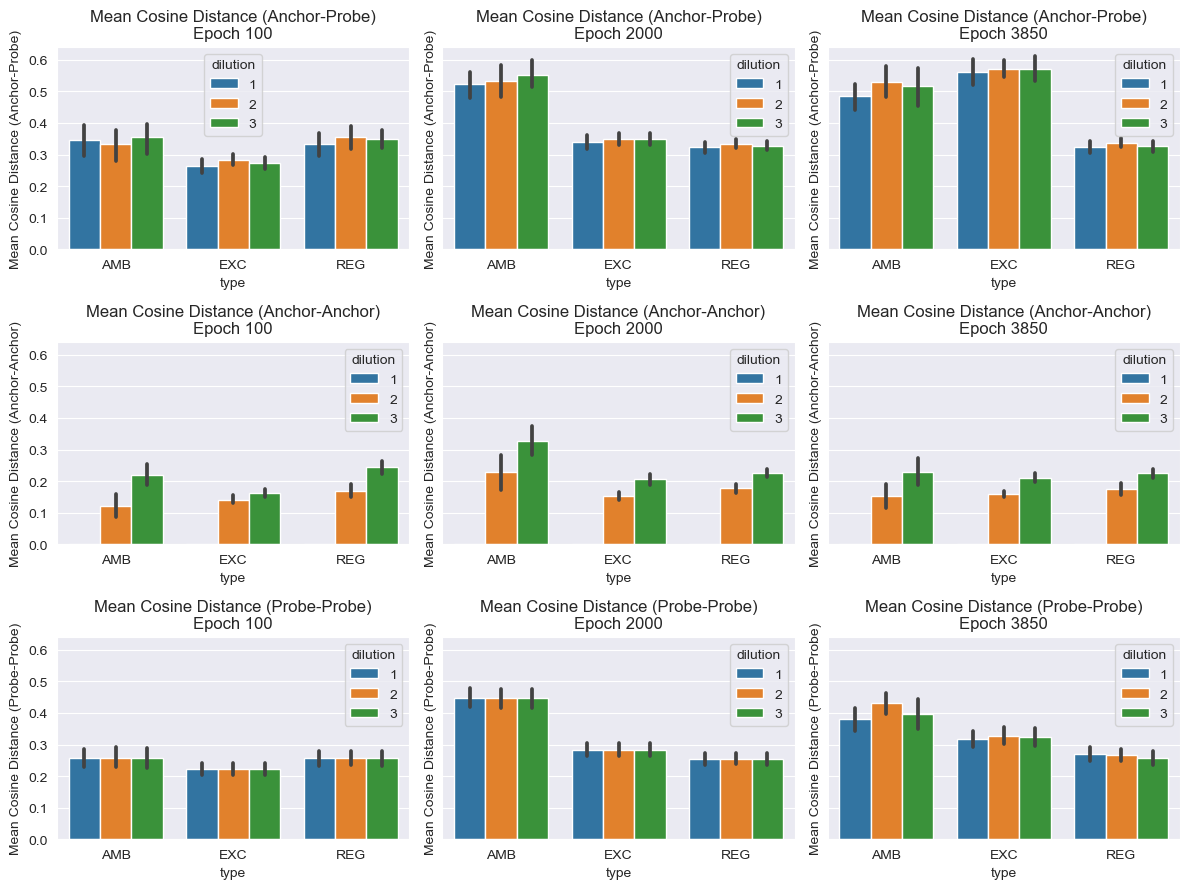

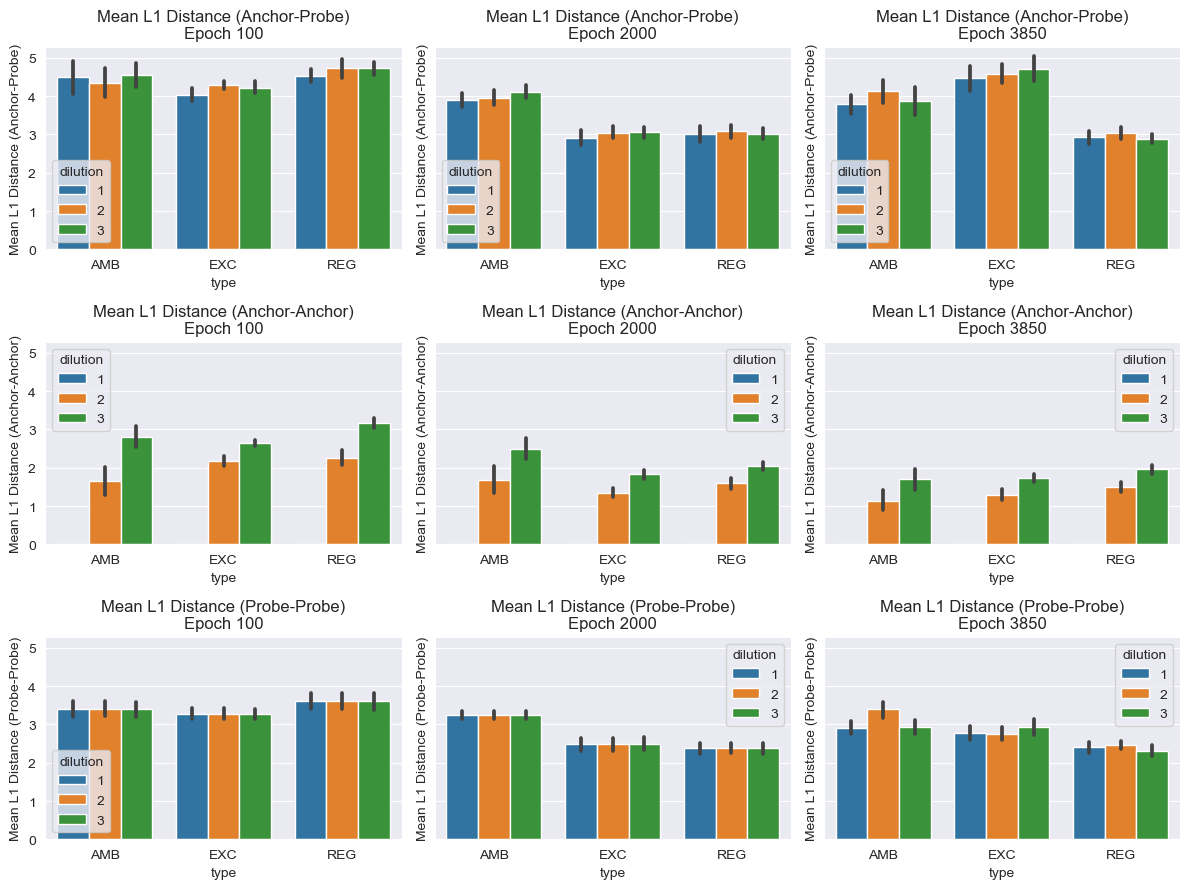

In [10]:
distance_mapping = {
    'aa': 'Anchor-Anchor',
    'ap': 'Anchor-Probe',
    'pp': 'Probe-Probe'
}

min_epoch = all_anchors_data['epoch'].min()
max_epoch = all_anchors_data['epoch'].max()

for metric in ['cosine', 'l1']:
    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharey='all')

    for distance, ax in zip(['ap', 'aa', 'pp'], axs):
        for epoch, sub_ax in zip([100, 2000, max_epoch], ax):
            sns.barplot(data=results_df[results_df['epoch'] == epoch], x='type',
                        y=f'mean_{distance}_{metric}_distance',
                        hue='dilution', ax=sub_ax, ci=68)
            sub_ax.set_ylabel(f'Mean {metric.title()} Distance ({distance_mapping[distance]})')
            sub_ax.set_title(f'Mean {metric.title()} Distance ({distance_mapping[distance]})\nEpoch {epoch}')

    plt.tight_layout()
    plt.show()